In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from condlib import conductance_matrix_WRITE
from timeit import default_timer as timer

In [41]:
# Memory array parameters
rL = 4.8
rHRS = 1e6
n = 64
vWrite = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

In [42]:
hubList = []
lsbList = []
WLvoltagesList = []
BLvoltagesList = []
cellVoltagesList = []

In [43]:
for v in vWrite:
    # Voltages for BLs and WLs (V/3 write scheme in this case)
    vBLsel = 0.0
    vBLnsel = 2.0 * v / 3.0
    vWLsel = v
    vWLnsel = 1.0 * v / 3.0

    start_t = timer()
    # Create conductance matrix
    conductancematrix, iinvector = conductance_matrix_WRITE(n, rL, rHRS,
                                                            vWLsel, vWLnsel, vBLsel, vBLnsel,
                                                            isel=n-1, jsel=n-1, verbose=False)
    # Convert to sparse matrix (CSR)
    conductancematrix = csr_matrix(conductancematrix)
    # Solve
    voltages = spsolve(conductancematrix, iinvector)
    stop_t = timer()

    # Separate WL and BL nodes and calculate cell voltages
    WLvoltages = voltages[:n*n].reshape((n, n))
    BLvoltages = voltages[n*n:].reshape((n, n))
    WLvoltagesList.append(WLvoltages)
    BLvoltagesList.append(BLvoltages)

    cellVoltages = abs(BLvoltages - WLvoltages)
    cellVoltagesList.append(cellVoltages)

    # Calculate Highest Unselected Bit and Lowest Selected Bit
    hub = cellVoltages[0][0]
    lsb = cellVoltages[n-1][n-1]
    hubList.append(hub)
    lsbList.append(lsb)
    
    print "{:.4f} sec".format(stop_t - start_t)
    print "Write voltage          : {:.4f} V".format(v)
    print "Highest unselected bit : {:.4f} V".format(hub)
    print "Lowest selected bit    : {:.4f} V".format(lsb)

2.1375 sec
Write voltage          : 0.5000 V
Highest unselected bit : 0.1666 V
Lowest selected bit    : 0.4965 V
2.2579 sec
Write voltage          : 1.0000 V
Highest unselected bit : 0.3331 V
Lowest selected bit    : 0.9929 V
2.4417 sec
Write voltage          : 2.0000 V
Highest unselected bit : 0.6663 V
Lowest selected bit    : 1.9859 V
2.1314 sec
Write voltage          : 3.0000 V
Highest unselected bit : 0.9994 V
Lowest selected bit    : 2.9788 V
1.9659 sec
Write voltage          : 4.0000 V
Highest unselected bit : 1.3325 V
Lowest selected bit    : 3.9717 V
1.9686 sec
Write voltage          : 5.0000 V
Highest unselected bit : 1.6657 V
Lowest selected bit    : 4.9647 V
2.0105 sec
Write voltage          : 6.0000 V
Highest unselected bit : 1.9988 V
Lowest selected bit    : 5.9576 V


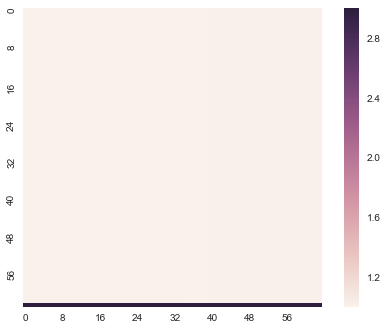

In [44]:
sns.heatmap(WLvoltagesList[3], square=True, xticklabels=n/8, yticklabels=n/8)
plt.savefig("figures/write_mapWL_{}.png".format(n))

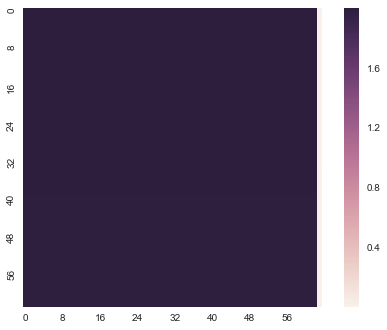

In [45]:
sns.heatmap(BLvoltagesList[3], square=True, xticklabels=n/8, yticklabels=n/8)
plt.savefig("figures/write_mapBL_{}.png".format(n))

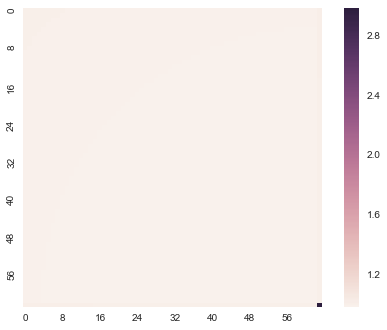

In [46]:
sns.heatmap(cellVoltagesList[3], square=True, xticklabels=n/8, yticklabels=n/8)
plt.savefig("figures/write_mapCell_{}.png".format(n))

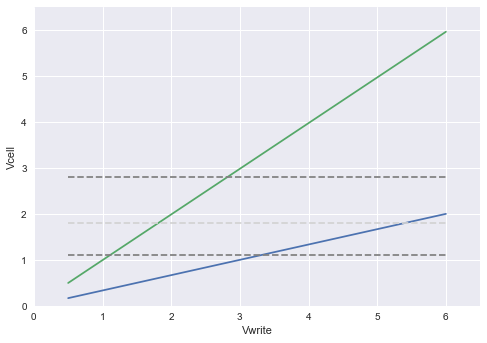

In [47]:
plt.plot(vWrite, hubList, vWrite, lsbList)
plt.plot([0.5, 6], [2.8, 2.8], [0.5, 6], [1.1, 1.1], c='gray', ls='--')
plt.plot([0.5, 6], [1.8, 1.8], c='lightgray', ls='--')
plt.xlim([0,6.5])
plt.ylim([0,6.5])
plt.ylabel("Vcell")
plt.xlabel("Vwrite")
plt.savefig("figures/write_margin_{}.png".format(n))
plt.show()